##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("Train.csv", sep=',')
train_data.drop(train_data.filter(regex="Unname"),axis = 1,inplace=True)
test_data = pd.read_csv("Test.csv", sep=',')
X,y = train_data['text'],train_data['sentiment']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.28)

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from bs4 import BeautifulSoup
import re
import unidecode
from nltk.tokenize import TweetTokenizer
from string import punctuation
import contractions
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stopwords = []
# exclude words from stopwords list
for i in stop_words:
    if i != 'not' and i != 'no':
        stopwords.append(i)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/heyonglin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/heyonglin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/heyonglin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

def remove_email(text):
    return re.sub(r'[\.a-zA-Z0-9_-]*@[\.a-zA-Z0-9_-]*', '', text)


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text
def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def remove_punc(text):
    return ''.join([i.casefold() for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


#  ps.stem(word)

def remove_not_alpha(text):
    return re.sub(r'[^\s\.a-zA-Z0-9_-]+', '', text)

def preprocess(text):
    
#     text = text.replace(r'\n','').replace(r'\m','').replace(r'\r','').replace(r'\t','') 
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_stopwords = remove_stopwords(no_num)
    no_alpha = remove_not_alpha(no_stopwords)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def prepare(text): 
    res = []
    for line in text:
        line = preprocess(line) 
        res.append(line)
      
    return res    
X_train = prepare(X_train)
X_valid = prepare(X_valid)    


In [4]:
#要调参
from sklearn.feature_extraction.text import CountVectorizer
BoW_vectorizer = CountVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_valid)
X_train_BoW.shape

(15697, 128006)

In [276]:
#要调参
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_tfidf = tfidf_vectorizer.transform(X_valid)
X_train_tfidf.shape

(15697, 127405)

In [5]:
#k要调参
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2,k=1000)
x_train_chi = selector.fit_transform(X_train_BoW ,y_train)
x_test_chi = selector.transform(X_test_BoW)

In [12]:
#threshold要调参
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold= 0.0001)
x_var_train = selector.fit_transform(X_train_BoW, y_train)
x_var_test = selector.transform(X_test_BoW)
x_var_train.shape

(15697, 19463)

Baseline-Model

In [155]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy= 'most_frequent')
model = clf.fit(x_train_chi,y_train)
model.score(x_test_chi,y_valid)

0.5867321867321867

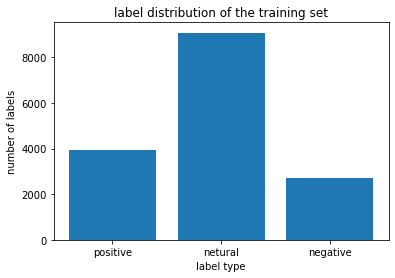

In [156]:
import matplotlib.pyplot as plt
import collections
counter = dict(collections.Counter(y_train))
label = ['positive','netural','negative']
data = [counter['positive'],counter['neutral'],counter['negative']]
plt.bar(label, data)
plt.title('label distribution of the training set')
plt.xlabel('label type')
plt.ylabel('number of labels')
plt.show()

Logistic Regression

In [6]:
#C, solver, multi_class, penalty, max_iter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(solver= 'sag', C = 0.5).fit(x_train_chi, y_train)
y_train_predicted = lr.predict(x_train_chi)
print("training accuracy ", np.mean(y_train_predicted == y_train))
lr_acc = np.mean(cross_val_score(lr,x_test_chi,y_valid,cv = 5))
print('validation accuracy: ' ,lr_acc)
# y_predicted = lr.predict(x_test_chi)
print('prediction accuracy: ',lr.score(x_test_chi, y_valid))


training accuracy  0.7268904886284003
validation accuracy:  0.6496314496314495
prediction accuracy:  0.6691236691236692


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(solver= 'sag', C = 0.5).fit(x_var_train, y_train)
y_train_predicted = lr.predict(x_var_train)
print("training accuracy ", np.mean(y_train_predicted == y_train))
lr_acc = np.mean(cross_val_score(lr,x_var_test,y_valid,cv = 5))
print('validation accuracy: ' ,lr_acc)
# y_predicted = lr.predict(x_test_chi)
print('prediction accuracy: ',lr.score(x_var_test, y_valid))

training accuracy  0.9164808562145633


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


validation accuracy:  0.6340704340704341
prediction accuracy:  0.6594594594594595


In [57]:
from sklearn.model_selection import GridSearchCV
parameters_lr = {'solver':('newton-cg','lbfgs','sag','saga'),'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],'multi_class':('auto','ovr','multinomial')}
lr = LogisticRegression()
p = GridSearchCV(lr,parameters_lr)
p.fit(x_train_chi,y_train)


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heyonglin/opt/anaconda3

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'multi_class': ('auto', 'ovr', 'multinomial'),
                         'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')})

In [59]:
p.best_params_

{'C': 1, 'multi_class': 'auto', 'solver': 'saga'}

In [7]:
#alpha
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(x_train_chi, y_train)
y_train_predicted = nb.predict(x_train_chi)
print("training accuracy ", np.mean(y_train_predicted == y_train))
nb_acc = np.mean(cross_val_score(nb,x_test_chi,y_valid,cv = 5))
print('validation accuracy: ' ,nb_acc)
print('prediction accuracy: ',nb.score(x_test_chi, y_valid))


training accuracy  0.684143466904504
validation accuracy:  0.638001638001638
prediction accuracy:  0.6447174447174447


In [266]:
#C, kernel, degree, gamma, max_iter, decision_function_shape
from sklearn.svm import SVC
clf = SVC(kernel="rbf", C = 10, gamma = 0.01).fit(x_train_chi, y_train)
y_train_predicted = clf.predict(x_train_chi)
print("training accuracy ", np.mean(y_train_predicted == y_train))
clf_acc = np.mean(cross_val_score(clf,x_test_chi,y_valid,cv = 5))
print('validation accuracy: ' ,clf_acc)
# y_predicted = lr.predict(x_test_chi)
print('prediction accuracy: ',clf.score(x_test_chi, y_valid))

training accuracy  0.7117920621774861
validation accuracy:  0.6479934479934479
prediction accuracy:  0.6658476658476659


In [199]:
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(), param_grid={"C":[0.01,0.1, 1, 10,100], "gamma":[1, 0.1, 0.01]}, cv=4)  
grid.fit(x_train_chi, y_train)



GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01]})

In [ ]:

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimator = [('lr', LogisticRegression(solver= 'sag', C = 0.75, multi_class="multinomial")),
            ('clf', SVC(kernel="linear")),
            ('nb', MultinomialNB(alpha = 3))]
clf2 = StackingClassifier(estimators= estimator, final_estimator=LogisticRegression())
r = clf2.fit(x_train_chi, y_train)
print('prediction accuracy: ',r.score(x_test_chi, y_valid))

In [50]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time

t0 = time.time()
lr = LogisticRegression(solver='sag',multi_class='multinomial',C = 0.8, max_iter=200 ).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of logtistic regression classifier: {} s". format(round(t1,3)))

lr_acc = np.mean(cross_val_score(lr,x_test_chi,y_valid,cv=5))
print('validation accuracy: ',lr_acc)
y_train_predicted = lr.predict(x_train_chi)
print('Training accuracy: ', np.mean(y_train_predicted == y_train))

y_pred = lr.predict(x_test_chi)
precision = precision_score(y_valid, y_pred, average="macro")
print('Macro Precision: %f ' % precision)
recall = recall_score(y_valid, y_pred, average="macro")
print('Macro Recall: %f ' % recall)
f1 = f1_score(y_valid, y_pred, average="macro")
print('Macro F1 score: %f ' % f1)

precision = precision_score(y_valid, y_pred, average="weighted")
print('Weighted Precision: %f ' % precision)
recall = recall_score(y_valid, y_pred, average="weighted")
print('Weighted Recall: %f ' % recall)
f1 = f1_score(y_valid, y_pred, average="weighted")
print('Weighted F1 score: %f ' % f1)


Excution time of logtistic regression classifier: 1.002 s
validation accuracy:  0.6332514332514332
Training accuracy:  0.9904440338918264
Macro Precision: 0.675531 
Macro Recall: 0.496441 
Macro F1 score: 0.519627 
Weighted Precision: 0.666291 
Weighted Recall: 0.657330 
Weighted F1 score: 0.614970 


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


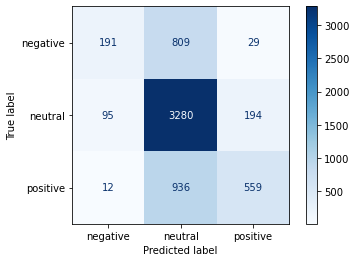

In [130]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr,x_test_chi, y_valid, cmap = plt.cm.Blues )
plt.show()

In [128]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time

t0 = time.time()
clf = SVC(kernel="rbf", C = 10, gamma = 0.01).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of SVM classifier: {} s". format(round(t1,3)))


clf_acc = np.mean(cross_val_score(clf,x_test_chi,y_valid,cv = 5))
print('validation accuracy: ',clf_acc)
y_train_predicted = clf.predict(x_train_chi)
print('Training accuracy: ', np.mean(y_train_predicted == y_train))


y_pred = clf.predict(x_test_chi)
precision = precision_score(y_valid, y_pred, average="macro")
print('Macro Precision: %f ' % precision)
recall = recall_score(y_valid, y_pred, average="macro")
print('Macro Recall: %f ' % recall)
f1 = f1_score(y_valid, y_pred, average="macro")
print('Macro F1 score: %f ' % f1)

precision = precision_score(y_valid, y_pred, average="weighted")
print('Weighted Precision: %f ' % precision)
recall = recall_score(y_valid, y_pred, average="weighted")
print('Weighted Recall: %f ' % recall)
f1 = f1_score(y_valid, y_pred, average="weighted")
print('Weighted F1 score: %f ' % f1)

Excution time of SVM classifier: 22.011 s
validation accuracy:  0.6347256347256348
Training accuracy:  0.9942027138943748
Macro Precision: 0.593479 
Macro Recall: 0.400209 
Macro F1 score: 0.383905 
Weighted Precision: 0.603405 
Weighted Recall: 0.610647 
Weighted F1 score: 0.525087 


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


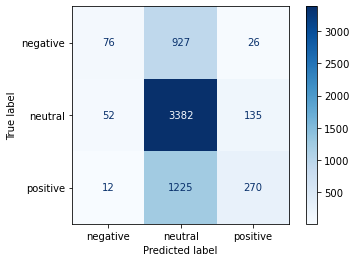

In [129]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test_chi, y_valid, cmap = plt.cm.Blues )
plt.show()

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time

t0 = time.time()
nb = MultinomialNB().fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of SVM classifier: {} s". format(round(t1,3)))


nb_acc = np.mean(cross_val_score(nb,x_test_chi,y_valid,cv = 5))
print('validation accuracy: ',nb_acc)
y_train_predicted = nb.predict(x_train_chi)
print('Training accuracy: ', np.mean(y_train_predicted == y_train))


y_pred = nb.predict(x_test_chi)
precision = precision_score(y_valid, y_pred, average="macro")
print('Macro Precision: %f ' % precision)
recall = recall_score(y_valid, y_pred, average="macro")
print('Macro Recall: %f ' % recall)
f1 = f1_score(y_valid, y_pred, average="macro")
print('Macro F1 score: %f ' % f1)

precision = precision_score(y_valid, y_pred, average="weighted")
print('Weighted Precision: %f ' % precision)
recall = recall_score(y_valid, y_pred, average="weighted")
print('Weighted Recall: %f ' % recall)
f1 = f1_score(y_valid, y_pred, average="weighted")
print('Weighted F1 score: %f ' % f1)

Excution time of SVM classifier: 0.034 s
validation accuracy:  0.638001638001638
Training accuracy:  0.684143466904504
Macro Precision: 0.604281 
Macro Recall: 0.595588 
Macro F1 score: 0.598743 
Weighted Precision: 0.642810 
Weighted Recall: 0.644717 
Weighted F1 score: 0.642771 


/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


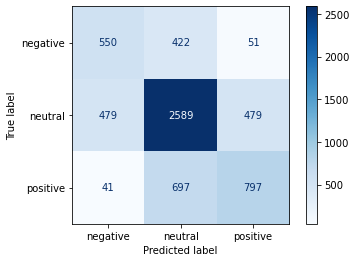

In [9]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb,x_test_chi, y_valid, cmap = plt.cm.Blues )
plt.show()